## 1. Preprocessing

In [1]:
%matplotlib inline
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot.metrics as skplt
import math
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import datasets

import gensim
import string
import pickle
import re
import nltk
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from collections import Counter
from sklearn.calibration import CalibratedClassifierCV

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

1.1 Load the data

In [3]:
con = sqlite3.connect('database.sqlite')

messages = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

print(messages.shape)
messages

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


1.2 Remove duplicates and null value

In [4]:
messages["Time"] = messages["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
sortedData = messages.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)
# drop row that include null value in text column and score column
messages = final[['Time','Summary','Score']].dropna()
final.shape

(364173, 10)

1.3 Distribution of original data

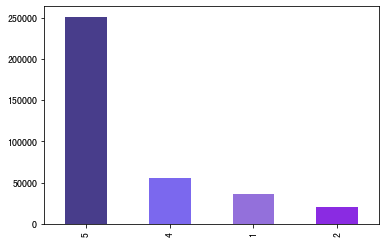

In [5]:
color_bar = ['darkslateblue','mediumslateblue','mediumpurple','blueviolet','darkorchid','darkviolet','mediumorchid',
             'm','fuchsia','magenta','orchid','deeppink','hotpink','pink','lightpink']
ax=messages.Score.value_counts().plot(kind='bar',color=color_bar)
fig = ax.get_figure()
fig.savefig("score_origin.png");

1.4 Transform origianl score to negative and positive

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

,Time,Summary,Score
138706,1999-10-08 08:00:00,EVERY book is educational,positive
138688,2007-11-11 08:00:00,"Love the book, miss the hard cover version",positive
138689,2007-10-04 08:00:00,chicken soup with rice months,positive
138690,2004-02-06 08:00:00,a good swingy rhythm for reading aloud,positive
138691,2002-04-10 08:00:00,A great way to learn the months,positive


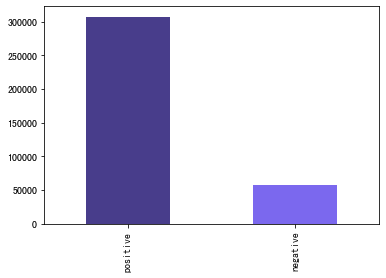

In [6]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

score = messages['Score']
messages['Score'] = score.map(partition)
text = messages['Summary']

# split and see the rating distribution
ax=messages['Score'].value_counts().plot(kind='bar',color=color_bar)
fig = ax.get_figure()
fig.savefig("score_pos_neg.png")
messages.head()

1.5 Down sampling and split the data

Down sampling and form a balanced dataset

,Time,Summary,Score
209484,2011-11-19 08:00:00,Good stuff!,positive
140711,2011-08-23 08:00:00,PAWS UP * * * * * *,positive
227135,2012-03-20 08:00:00,Choir Food,positive
225124,2012-03-26 08:00:00,Good Stuff!,positive
15481,2009-05-21 08:00:00,"Good drink, something different to try rather ...",positive
...,...,...,...
240366,2012-01-20 08:00:00,DON'T BUY HERE- You'll spend twice as much as ...,negative
350289,2012-06-23 08:00:00,Awful.,negative
115382,2011-05-19 08:00:00,Ruined a perfect thing.,negative
175291,2012-04-08 08:00:00,Upset tummies,negative


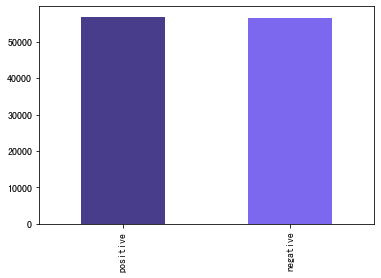

In [7]:
score = messages['Score']
summary = messages['Summary']
finalp = messages[messages.Score == 'positive']
finalp = finalp.sample(frac=0.185,random_state=1)

finaln = messages[messages.Score == 'negative']
finaln = finaln.sample(frac=0.99,random_state=1)


final = pd.concat([finalp,finaln],axis=0)
final['Score'].value_counts().plot(kind='bar',color=color_bar)
final

The data will be split into an training set and a test set with a test set ratio of 0.2

In [8]:
score = final['Score']
text = final['Summary']

x_train, x_test, y_train, y_test = train_test_split(text, score, test_size=0.2, random_state=50)

## 2. Data Cleaning

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

- Lowering
- Stop words removal
- Pruning (numbers and punctuation)
- POS(part of speech)
- Lemmatization

In [9]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivy_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ivy_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ivy_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# 获取单词的词性
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [11]:
def tokenize(text,wnl):
    tokens = nltk.word_tokenize(text)
    tagged_sent = pos_tag(tokens)     # 获取单词词性
#     tokens = [word for word in tokens if word not in stopwords.words('english')]
    lems = lem_tokens(tagged_sent, wnl)
    return ' '.join(lems)

In [12]:
def lem_tokens(tagged_sent, wnl):
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) # 词形还原
    return lemmas_sent

In [13]:
def lem_lower_pruning(x_train,x_test,wnl):
    intab = string.punctuation
    outtab = "                                "
    trantab = str.maketrans(intab, outtab)
    
    total=len(x_train)+len(x_test)
    cnt=0

    #--- Training set
    corpus = []
    for text in x_train:
        text = text.lower()
        text = text.translate(trantab)
        text=tokenize(text,wnl)
        corpus.append(text)
        cnt += 1
        if cnt%(int(total/20))==0:
            print ("%d%% finished" % (5*cnt/(int(total/20))))

    #--- Test set
    test_set = []
    for text in x_test:
        text = text.lower()
        text = text.translate(trantab)
        text=tokenize(text,wnl)
        test_set.append(text)
        cnt += 1
        if cnt%(int(total/20))==0:
            print ("%d%% finished" % (5*cnt/(int(total/20))))
    
    df = pd.DataFrame({'Before': x_train, 'After': corpus})
    print(df.head(10))

    prediction = dict()
    return corpus, test_set

In [14]:
wnl = WordNetLemmatizer()
x_train, x_test = lem_lower_pruning(x_train,x_test,wnl)

5% finished
10% finished
15% finished
20% finished
25% finished
30% finished
35% finished
40% finished
45% finished
50% finished
55% finished
60% finished
65% finished
70% finished
75% finished
80% finished
85% finished
90% finished
95% finished
100% finished
                                        Before  \
177116         It's Definitely Not Chunky Soup   
351105                      Tasteless and Hard   
421436              Good, fresh, pliable beans   
325735               My 3 cats wouldn't eat it   
50097                      Awesome Coconut oil   
106714                          Way Overpriced   
517177  Great licorice flavor in a hard candy!   
73605                         A slimmer Margie   
233668                     horrible experience   
110652     A little greasy but EXTREMELY tasty   

                                        After  
177116        it s definitely not chunky soup  
351105                     tasteless and hard  
421436                good fresh pliable bean

## 3. Feature Extraction

### 3.1 Uni-Gram

In [15]:
unigram = CountVectorizer()
x_uni = unigram.fit_transform(x_train)
x_uni_test = unigram.transform(x_test)

### 3.2 TF-IDF

In [16]:
tf_idf_vect = TfidfVectorizer()
x_tfidf = tf_idf_vect.fit_transform(x_train)
x_tfidf_test = tf_idf_vect.transform(x_test)

## 4. Fitting the models

### 4.1 Result Plot and Analysis

In [17]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

In [18]:
def result_plot(prediction):
    cmp = 0
    colors = ['b', 'g', 'y', 'm', 'k']
    for model, predicted in prediction.items():
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1

    plt.title('Classifiers comparaison with ROC')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 4.2 Multinomial Naïve Bayes model

In [19]:
prediction_mnb = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [20]:
mnb_uni_model = MultinomialNB().fit(x_uni, y_train)
prediction_mnb['Multinomial-NB-uni'] = mnb_uni_model.predict(x_uni_test)

In [35]:
print("uni-Gram F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_mnb['Multinomial-NB-uni'],average='macro')))

uni-Gram F1-Score on test set: 0.857


In [21]:
mnb_tfidf_model = MultinomialNB().fit(x_tfidf, y_train)
prediction_mnb['Multinomial-NB-tfidf'] = mnb_tfidf_model.predict(x_tfidf_test)

In [36]:
print("tfidf F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_mnb['Multinomial-NB-tfidf'],average='macro')))

tfidf F1-Score on test set: 0.846


Result Analysis

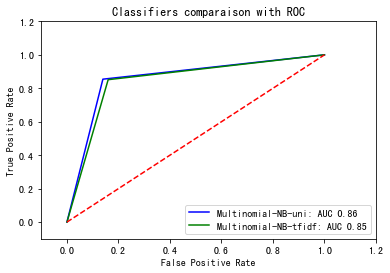

In [22]:
result_plot(prediction_mnb)

### 4.3 Bernoulli Naïve Bayes model

In [23]:
prediction_bnb = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [24]:
bnb_uni_model = BernoulliNB().fit(x_uni, y_train)
prediction_bnb['Bernoulli-NB-uni'] = bnb_uni_model.predict(x_uni_test)

In [37]:
print("uni-Gram F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_bnb['Bernoulli-NB-uni'],average='macro')))

uni-Gram F1-Score on test set: 0.858


In [25]:
bnb_tfidf_model = BernoulliNB().fit(x_tfidf, y_train)
prediction_bnb['Bernoulli-NB-tfidf'] = bnb_tfidf_model.predict(x_tfidf_test)

In [38]:
print("tfidf F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_bnb['Bernoulli-NB-tfidf'],average='macro')))

tfidf F1-Score on test set: 0.858


Result Analysis

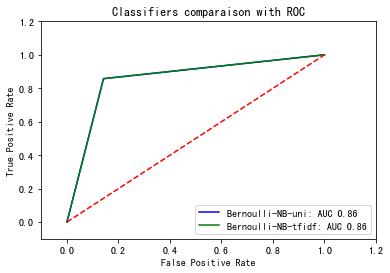

In [26]:
result_plot(prediction_bnb)

### 4.4 Logistic regression model

In [27]:
prediction_lr = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [28]:
lr_uni_model = LogisticRegression(C=1e5,n_jobs=-1)
lr_uni_model.fit(x_uni, y_train)
prediction_lr['Logistic_lr_uni'] = lr_uni_model.predict(x_uni_test)

In [39]:
print("uni-Gram F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_lr['Logistic_lr_uni'],average='macro')))

uni-Gram F1-Score on test set: 0.861


In [29]:
lr_tfidf_model = LogisticRegression(C=1e5,n_jobs=-1).fit(x_tfidf, y_train)
prediction_lr['Logistic_lr_tfidf'] = lr_tfidf_model.predict(x_tfidf_test)

In [40]:
print("tfidf F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_lr['Logistic_lr_tfidf'],average='macro')))

tfidf F1-Score on test set: 0.860


Result Analysis

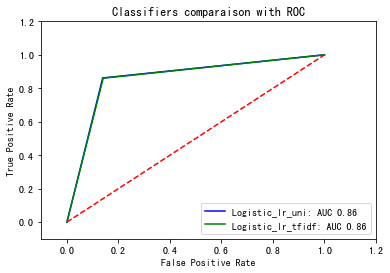

In [30]:
result_plot(prediction_lr)

### 4.5 SVM model

In [31]:
prediction_svm = dict()

In [32]:
svm_uni_model = SGDClassifier(n_jobs = -1).fit(x_uni, y_train)
prediction_svm['svm_uni'] = svm_uni_model.predict(x_uni_test)

In [42]:
print("uni-Gram F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_svm['svm_uni'],average='macro')))

uni-Gram F1-Score on test set: 0.867


In [33]:
svm_tfidf_model = SGDClassifier(n_jobs = -1).fit(x_tfidf, y_train)
prediction_svm['svm_tfidf'] = svm_tfidf_model.predict(x_tfidf_test)

In [41]:
print("tfidf F1-Score on test set: %0.3f"%(f1_score(y_test, prediction_svm['svm_tfidf'],average='macro')))

tfidf F1-Score on test set: 0.866


Result Analysis

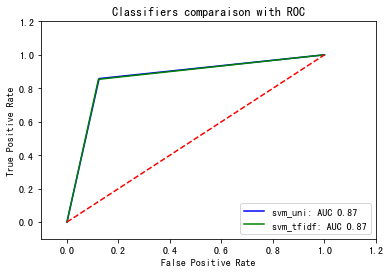

In [34]:
result_plot(prediction_svm)